In [1]:
import numpy as np

np.set_printoptions(precision=3)

## Working Example

In [2]:
Q = np.array([
    [ 0.00, -0.80, -0.60],
    [ 0.80, -0.36,  0.48],
    [ 0.60,  0.48, -0.64]
])

D = np.array([
    [9, 0, 0],
    [0, 4, 0],
    [0, 0, 1]
])

A = Q.T @ D @ Q

In [3]:
A

array([[ 2.92 , -0.864,  1.152],
       [-0.864,  6.509,  3.322],
       [ 1.152,  3.322,  4.571]])

In [4]:
e_vals, e_vectors = np.linalg.eig(A)

In [5]:
print(e_vals)
print(e_vectors)

[ 4.  1.  9.]
[[  8.000e-01  -6.000e-01  -3.872e-17]
 [ -3.600e-01  -4.800e-01   8.000e-01]
 [  4.800e-01   6.400e-01   6.000e-01]]


## Power Iteration

In [6]:
def power_iteration(A, v=None):
    if v is None:
        v = np.random.normal(size=A.shape[1])
    previous = np.empty(shape=A.shape[1])
    while True:
        previous[:] = v
        v = A @ v
        v = v / np.linalg.norm(v)
        if np.all(np.abs(v - previous) < 0.00001):
            break
    return v

In [7]:
power_iteration(A, v=[1, 0, 0])

array([ 0.8 , -0.36,  0.48])

In [8]:
A @ np.array([1, 0, 0])

array([ 2.92 , -0.864,  1.152])

## Simultaneous Orthogonalization

In [9]:
def simultaneous_orthogonalization(A):
    Q = np.random.normal(size=A.shape)
    previous = np.empty(shape=Q.shape)
    for i in range(100):
        previous[:] = Q
        Qp = A @ Q
        Q = Qp / np.linalg.norm(Qp, axis=0)
        #Q, R = np.linalg.qr(X)
        if np.all(np.abs(Q - previous) < 0.00001):
            break
    return Q

In [10]:
simultaneous_orthogonalization(A)

array([[ -1.711e-06,  -7.051e-06,   3.409e-08],
       [ -8.000e-01,  -8.000e-01,  -8.000e-01],
       [ -6.000e-01,  -6.000e-01,  -6.000e-01]])

In [11]:
def simultaneous_orthogonalization(A):
    X = np.random.normal(size=A.shape)
    Q, R = np.linalg.qr(X)
    memo = []; memo.append(Q)
    previous = np.empty(shape=Q.shape)
    for i in range(100):
        previous[:] = Q
        X = A @ Q
        Q, R = np.linalg.qr(X)
        memo.append(Q)
        if np.all(np.abs(Q - previous) < 0.001):
            break
    return Q, memo

In [12]:
Q, basies = simultaneous_orthogonalization(A)
Q

array([[ -7.279e-04,   8.000e-01,  -6.000e-01],
       [ -7.997e-01,  -3.607e-01,  -4.800e-01],
       [ -6.004e-01,   4.795e-01,   6.400e-01]])

## 3D Rendering of Basis

In [18]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [48]:
def plot_basis(ax, Q, final_Q=None):
    ax.auto_scale_xyz([-1, 1], [-1, 1], [-1, 1])
    if final_Q is not None:
        for i in range(final_Q.shape[1]):
            ax.quiver(0, 0, 0, 
                      final_Q[0, i], final_Q[1, i], final_Q[2, i], 
                      pivot='tail', color='black', alpha=0.5,
                      zorder=0)        
    for i in range(Q.shape[1]):
        ax.quiver(0, 0, 0, Q[0, i], Q[1, i], Q[2, i], 
                  pivot='tail', color='black', zorder=10)
    ax.scatter([0], [0], [0], color='black', s=50)
    ax.set_xlim([-1, 1])
    ax.set_xticks([-1.0, 0.0, 1.0])
    ax.set_ylim([-1, 1])
    ax.set_yticks([-1.0, 0.0, 1.0])
    ax.set_zlim([-1, 1])
    ax.set_zticks([-1.0, 0.0, 1.0])


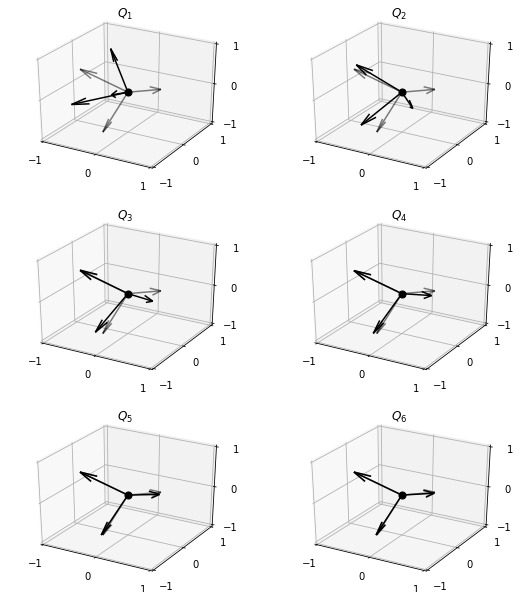

In [52]:
fig = plt.figure(figsize=(12*0.75, 14*0.75))

for i, Q in enumerate(basies[:6]):
    ax = fig.add_subplot(3, 2, i+1, projection='3d')
    plot_basis(ax, Q, basies[-1])
    ax.set_title("$Q_{{{}}}$".format(i+1))